## **MODELAGEM DE DADOS (sales.csv)**

In [8]:
#  Bibliotecas utilizadas
import pandas as pd, numpy as np, matplotlib.pyplot as plt, joblib
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

pd.set_option("display.float_format", lambda x: f"{x:,.4f}")
RANDOM_STATE = 42


## 1) Carregamento do Dataset

In [9]:

df = pd.read_csv('/content/sales.csv')
print(df.info())
display(df.head(10))
display(df.describe(include='all').T)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143 entries, 0 to 142
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          143 non-null    object 
 1   Weekly_Sales  143 non-null    float64
 2   Holiday_Flag  143 non-null    int64  
 3   Temperature   143 non-null    float64
 4   Fuel_Price    143 non-null    float64
 5   CPI           143 non-null    float64
 6   Unemployment  143 non-null    int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 7.9+ KB
None


,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,05-02-2010,"1,643,690.9000",0,42.3100,"2,572.0000",211.0964,8106
1,12-02-2010,"1,641,957.4400",1,38.5100,"2,548.0000",211.2422,8106
2,19-02-2010,"1,611,968.1700",0,39.9300,"2,514.0000",211.2891,8106
3,26-02-2010,"1,409,727.5900",0,46.6300,"2,561.0000",211.3196,8106
4,05-03-2010,"1,554,806.6800",0,46.5000,"2,625.0000",211.3501,8106
5,12-03-2010,"1,439,541.5900",0,57.7900,"2,667.0000",211.3806,8106
6,19-03-2010,"1,472,515.7900",0,54.5800,2.7200,211.2156,8106
7,26-03-2010,"1,404,429.9200",0,51.4500,"2,732.0000",211.0180,8106
8,02-04-2010,"1,594,968.2800",0,62.2700,"2,719.0000",210.8204,7808
9,09-04-2010,"1,545,418.5300",0,65.8600,2.7700,210.6229,7808


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Date,143,143,05-02-2010,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Weekly_Sales,143.0000,NaN,NaN,NaN,"1,555,264.3976","155,980.7678","1,316,899.3100","1,458,104.6900","1,534,849.6400","1,614,892.0300","2,387,950.2000"
Holiday_Flag,143.0000,NaN,NaN,NaN,0.0699,0.2559,0.0000,0.0000,0.0000,0.0000,1.0000
Temperature,143.0000,NaN,NaN,NaN,68.3068,14.2505,35.4000,58.2650,69.6400,80.4850,91.6500
Fuel_Price,143.0000,NaN,NaN,NaN,"2,879.4804","1,068.1121",2.6400,"2,668.5000","3,227.0000","3,554.5000","3,907.0000"
CPI,143.0000,NaN,NaN,NaN,215.9969,4.3509,210.3374,211.5493,215.4599,220.5313,223.4443
Unemployment,143.0000,NaN,NaN,NaN,"7,610.4196",383.7488,"6,573.0000","7,348.0000","7,787.0000","7,838.0000","8,106.0000"


## 2) Exploração dos dados

Correlação com Weekly_Sales (ordenada)
Weekly_Sales    1.0000
CPI             0.2254
Holiday_Flag    0.1949
Fuel_Price      0.1246
Unemployment   -0.0980
Temperature    -0.2227
Name: Weekly_Sales, dtype: float64


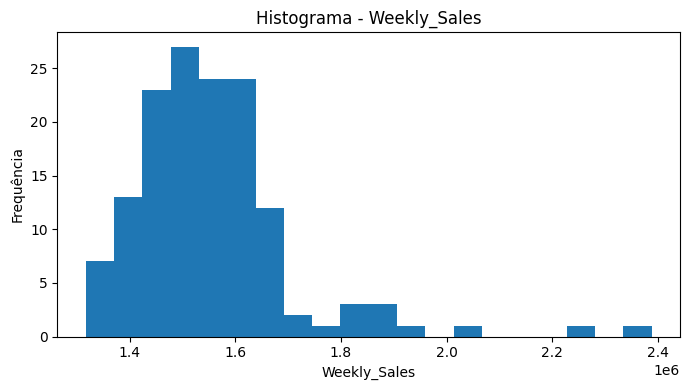

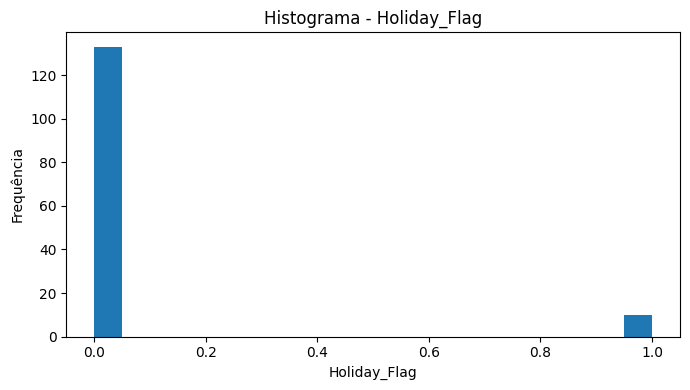

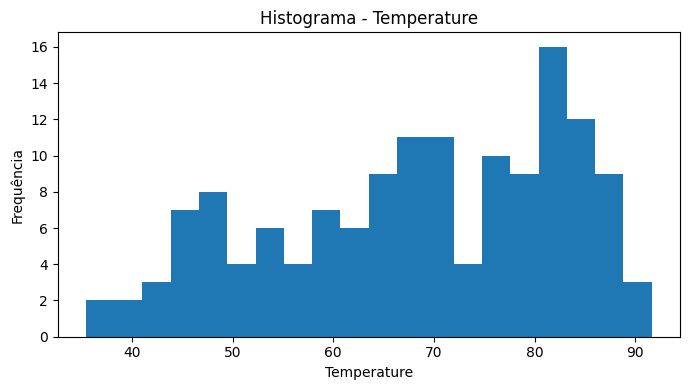

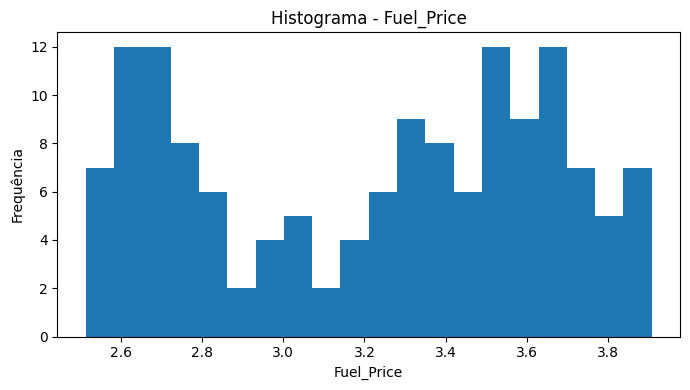

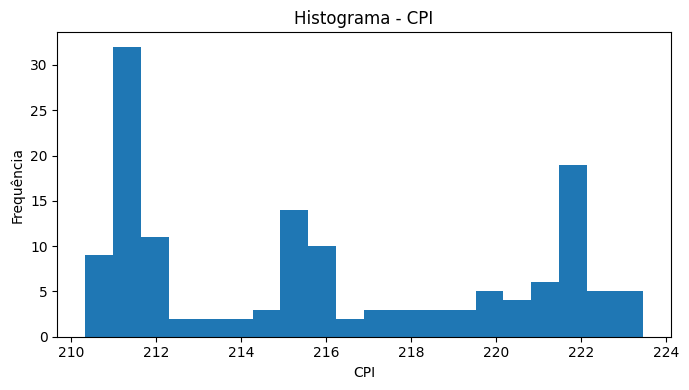

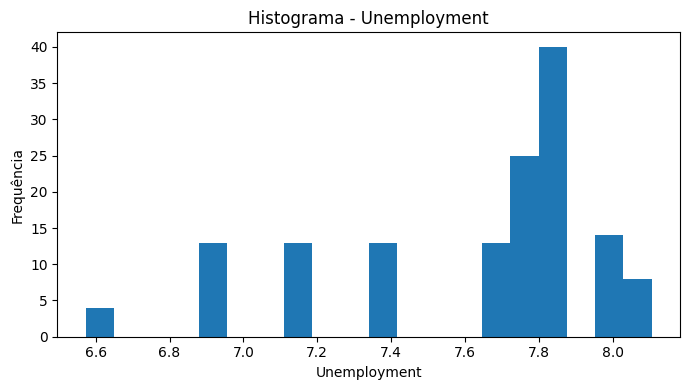

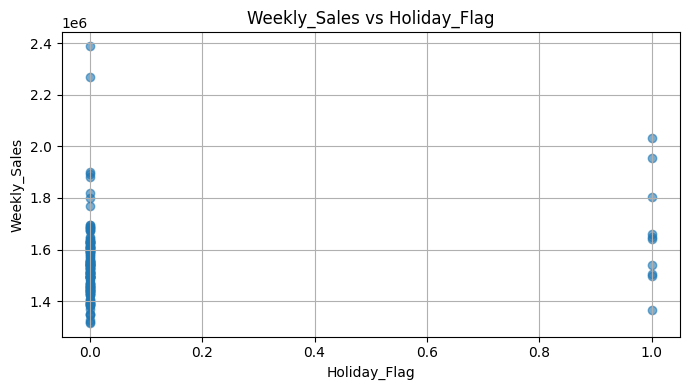

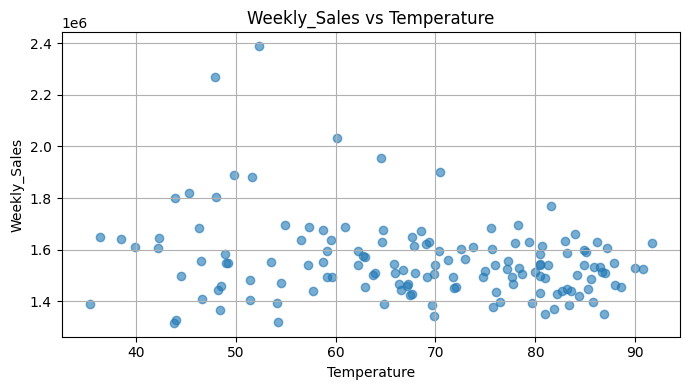

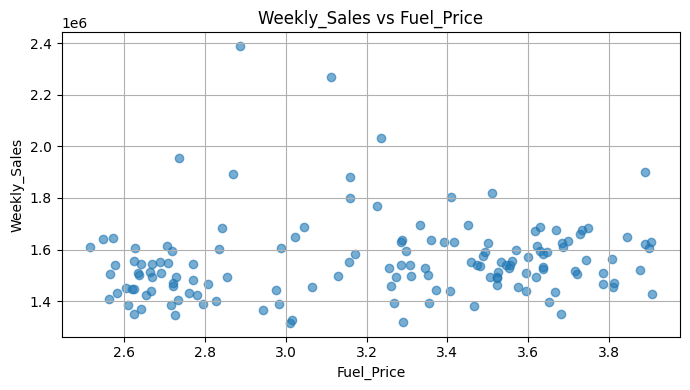

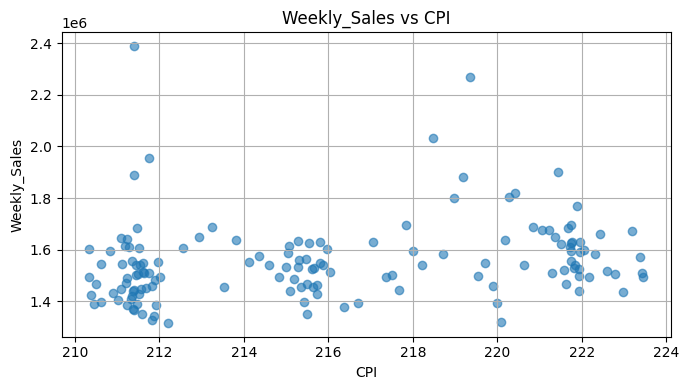

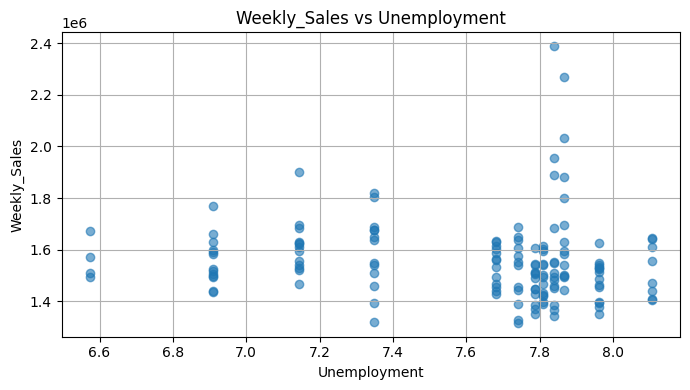

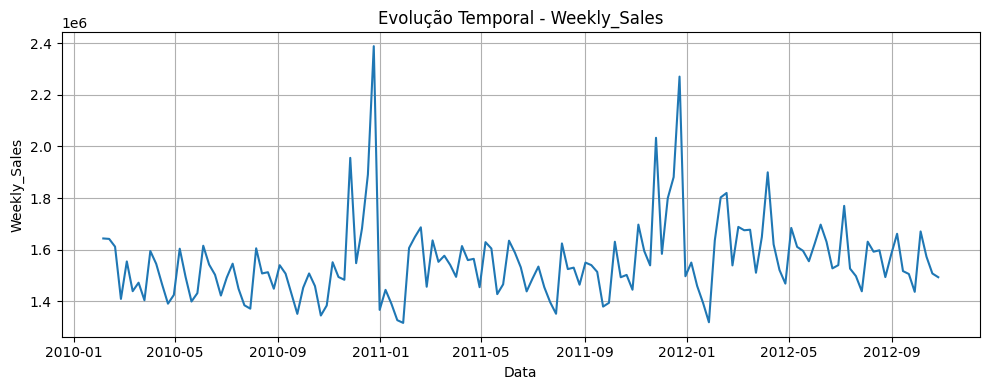

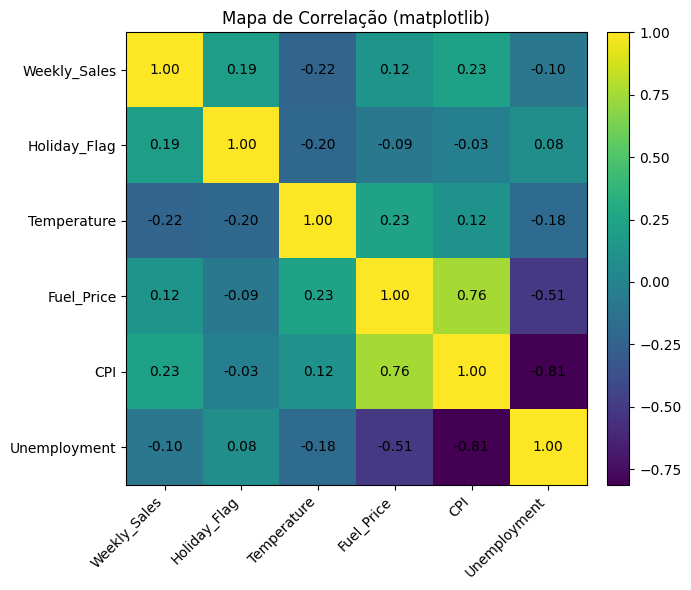

In [10]:
# Conversões iniciais e ajustes de escala
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y', errors='coerce')
df["Fuel_Price"] = df["Fuel_Price"].apply(
    lambda x: int(round(x*1000)) if x < 10 else int(x))
df['Fuel_Price'] = df['Fuel_Price'] / 1000.0
df['Unemployment'] = df['Unemployment'] / 1000.0

# Correlação numérica
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
corr = df[num_cols].corr()
print("Correlação com Weekly_Sales (ordenada)")
print(corr['Weekly_Sales'].sort_values(ascending=False))

# Histogramas (uma figura por gráfico; sem cores específicas)
for col in num_cols:
    plt.figure(figsize=(7,4))
    plt.hist(df[col].dropna(), bins=20)
    plt.title(f"Histograma - {col}")
    plt.xlabel(col); plt.ylabel("Frequência")
    plt.tight_layout(); plt.show()

# Dispersões: Weekly_Sales vs cada preditora
predictors = [c for c in num_cols if c != 'Weekly_Sales']
for col in predictors:
    plt.figure(figsize=(7,4))
    plt.scatter(df[col], df['Weekly_Sales'], alpha=0.6)
    plt.title(f"Weekly_Sales vs {col}")
    plt.xlabel(col); plt.ylabel("Weekly_Sales")
    plt.grid(True); plt.tight_layout(); plt.show()

# Série temporal de vendas
plt.figure(figsize=(10,4))
plt.plot(df['Date'], df['Weekly_Sales'])
plt.title("Evolução Temporal - Weekly_Sales")
plt.xlabel("Data"); plt.ylabel("Weekly_Sales")
plt.grid(True); plt.tight_layout(); plt.show()

# Heatmap de correlação (matplotlib puro)
fig, ax = plt.subplots(figsize=(7,6))
im = ax.imshow(corr.values, aspect='auto')
ax.set_xticks(np.arange(len(corr.columns)))
ax.set_yticks(np.arange(len(corr.index)))
ax.set_xticklabels(corr.columns, rotation=45, ha="right")
ax.set_yticklabels(corr.index)
plt.title("Mapa de Correlação (matplotlib)")
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
for i in range(len(corr.index)):
    for j in range(len(corr.columns)):
        ax.text(j, i, f"{corr.values[i, j]:.2f}", ha="center", va="center")
plt.tight_layout(); plt.show()


## 3) Pré‑Processamento e Engenharia de Atributos

In [11]:
# Atributos temporais
iso = df['Date'].dt.isocalendar()
df['Year']        = df['Date'].dt.year
df['Quarter']     = df['Date'].dt.quarter
df['Month']       = df['Date'].dt.month
df['WeekOfYear']  = iso.week.astype(int)

# Sazonalidade cíclica
df['Week_sin'] = np.sin(2 * np.pi * df['WeekOfYear'] / 52.0)
df['Week_cos'] = np.cos(2 * np.pi * df['WeekOfYear'] / 52.0)

# Seleção de colunas
target_col = 'Weekly_Sales'
feature_cols = [
    'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment',
    'Year', 'Quarter', 'Month', 'WeekOfYear', 'Week_sin', 'Week_cos'
]

X = df[feature_cols].copy()
y = df[target_col].copy()

# Split 80/20
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Escalonamento (StandardScaler) das colunas numéricas
numeric_cols = [
    'Temperature', 'Fuel_Price', 'CPI', 'Unemployment',
    'Year', 'Quarter', 'Month', 'WeekOfYear', 'Week_sin', 'Week_cos'
]

scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled  = X_test.copy()
X_train_scaled[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test_scaled[numeric_cols]  = scaler.transform(X_test[numeric_cols])





## 4) Modelagem Preditiva e Avaliação

In [23]:

models = {
    "Regressão Linear": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=200, max_depth=5, random_state=RANDOM_STATE),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=RANDOM_STATE)
}
cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

rows = {}; table = []
for name, mdl in models.items():
    cv_r2 = cross_val_score(mdl, X_train, y_train, cv=cv, scoring='r2').mean()
    mdl.fit(X_train, y_train); preds = mdl.predict(X_test)
    r2 = r2_score(y_test, preds); mae = mean_absolute_error(y_test, preds); rmse = np.sqrt(mean_squared_error(y_test, preds))
    rows[name] = {"model": mdl, "preds": preds}
    table.append({"Modelo": name, "CV_R2_mean": cv_r2, "Test_R2": r2, "Test_MAE": mae, "Test_RMSE": rmse})

summary_df = pd.DataFrame(table).sort_values(by="Test_R2", ascending=False).reset_index(drop=True)
display(summary_df)

best_name = summary_df.iloc[0]["Modelo"]
best_model = rows[best_name]["model"]
best_preds = rows[best_name]["preds"]
joblib.dump(best_model, f"best_model_{best_name.replace(' ', '_').lower()}.joblib")
print("Melhor modelo:", best_name)



,Modelo,CV_R2_mean,Test_R2,Test_MAE,Test_RMSE
0,Regressão Linear,-0.0870,0.5483,"69,036.2782","104,529.3956"
1,Gradient Boosting,-0.3485,0.5034,"89,100.3351","109,593.8382"
2,Random Forest,-0.4782,0.3990,"95,404.4278","120,571.1634"


Melhor modelo: Regressão Linear


## 5) Visualizações dos Resultados


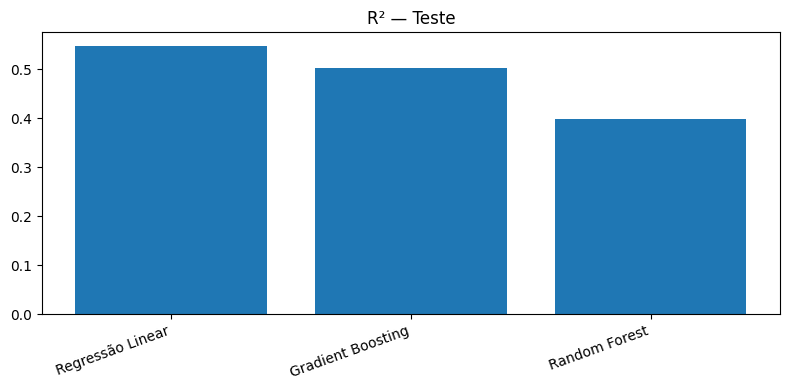

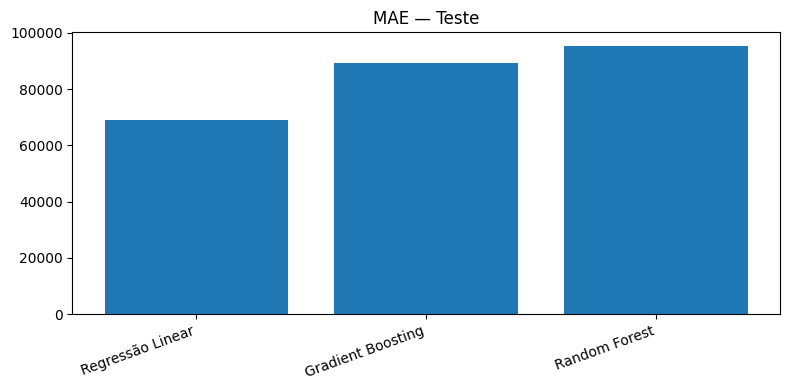

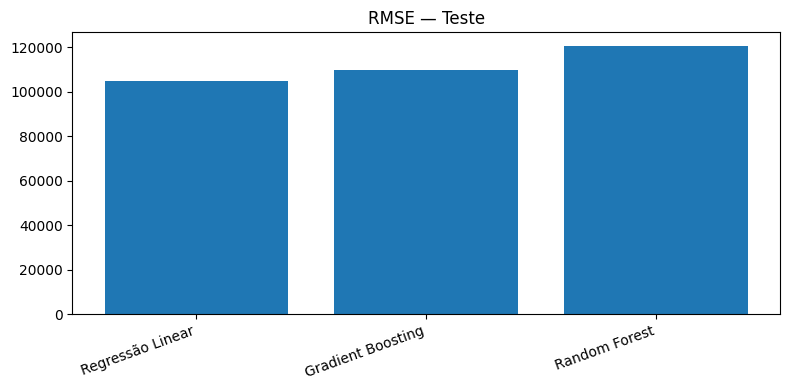

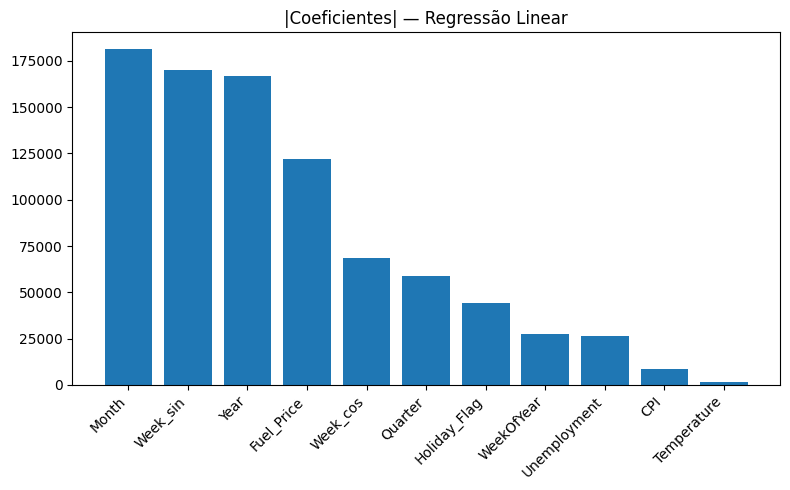

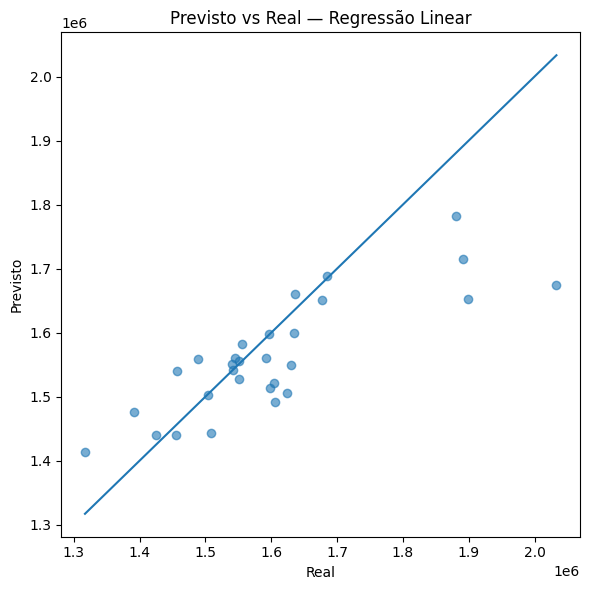

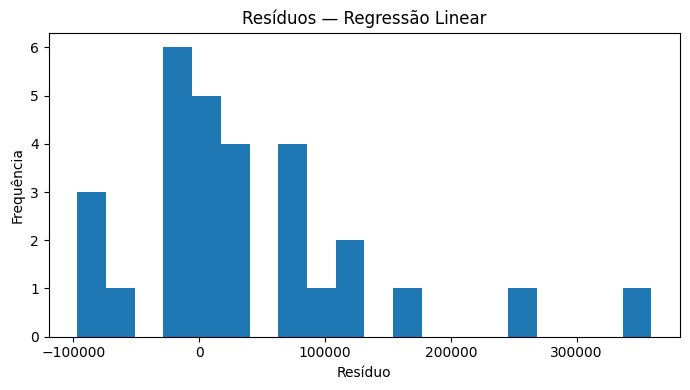

In [25]:
plt.figure(figsize=(8,4)); plt.bar(summary_df['Modelo'], summary_df['Test_R2']); plt.title("R² — Teste"); plt.xticks(rotation=20, ha='right'); plt.tight_layout(); plt.show()
plt.figure(figsize=(8,4)); plt.bar(summary_df['Modelo'], summary_df['Test_MAE']); plt.title("MAE — Teste"); plt.xticks(rotation=20, ha='right'); plt.tight_layout(); plt.show()
plt.figure(figsize=(8,4)); plt.bar(summary_df['Modelo'], summary_df['Test_RMSE']); plt.title("RMSE — Teste"); plt.xticks(rotation=20, ha='right'); plt.tight_layout(); plt.show()

# Importância ou coeficientes
if hasattr(best_model, "feature_importances_"):
    imp = pd.Series(best_model.feature_importances_, index=feature_cols).sort_values(ascending=False)
    plt.figure(figsize=(8,5)); plt.bar(imp.index, imp.values); plt.title(f"Importância — {best_name}"); plt.xticks(rotation=45, ha='right'); plt.tight_layout(); plt.show()
else:
    coefs = pd.Series(np.abs(best_model.coef_), index=feature_cols).sort_values(ascending=False)
    plt.figure(figsize=(8,5)); plt.bar(coefs.index, coefs.values); plt.title(f"|Coeficientes| — {best_name}"); plt.xticks(rotation=45, ha='right'); plt.tight_layout(); plt.show()

# Previsto vs Real
from math import inf
plt.figure(figsize=(6,6))
plt.scatter(y_test, best_preds, alpha=0.6)
lim_min = float(min(y_test.min(), best_preds.min()))
lim_max = float(max(y_test.max(), best_preds.max()))
plt.plot([lim_min, lim_max], [lim_min, lim_max])
plt.title(f"Previsto vs Real — {best_name}")
plt.xlabel("Real"); plt.ylabel("Previsto")
plt.tight_layout(); plt.show()

# Resíduos
residuals = y_test - best_preds
plt.figure(figsize=(7,4)); plt.hist(residuals, bins=20); plt.title(f"Resíduos — {best_name}"); plt.xlabel("Resíduo"); plt.ylabel("Frequência"); plt.tight_layout(); plt.show()